In [1]:
import motion_util as u
import scatter_plot as s
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mstats
from scipy import stats
from sklearn.decomposition import PCA
from scipy.cluster.vq import kmeans,vq
a=u.motionUtil(['d4fc6d71b812'],windows=2.5)
a.fetch_data_from_mysql('2017-03-10 11:03','2017-03-10 11:07',table='healthcare')

In [2]:
movement=[(1489115010,1489115052),(1489115070,1489115112),(1489115130,1489115172),(1489115190,1489115232),(1489115250,1489115292)]
def to_color(info,movement,color_list):
    for i in range(len(movement)):
        if  info[0] >= movement[i][0] and info[1] <= movement[i][1] :
            return color_list[i]
    return 'black'

Movement before outlier removal:  30
Turkey range:  -68.5 479.5
Movement after outlier removal:  30
NormaltestResult(statistic=7.902155535842347, pvalue=0.019233960854438972)
NormaltestResult(statistic=3.4898574721538385, pvalue=0.17465743529735292)
NormaltestResult(statistic=0.4371265697875697, pvalue=0.8036726174990404)
NormaltestResult(statistic=0.48212116644749003, pvalue=0.78579401901138457)
NormaltestResult(statistic=21.23701918416937, pvalue=2.4459066517091986e-05)
NormaltestResult(statistic=0.00042433623654767569, pvalue=0.99978785438778961)
NormaltestResult(statistic=5.5764383189117241, pvalue=0.061530692756256382)
NormaltestResult(statistic=2.497319979339593, pvalue=0.28688897359054261)
NormaltestResult(statistic=0.091325132181658913, pvalue=0.95536428011087815)
NormaltestResult(statistic=0.12734167502382152, pvalue=0.93831380641124751)
NormaltestResult(statistic=0.65865943301621299, pvalue=0.71940577767747838)
NormaltestResult(statistic=0.43712657052560033, pvalue=0.80367261

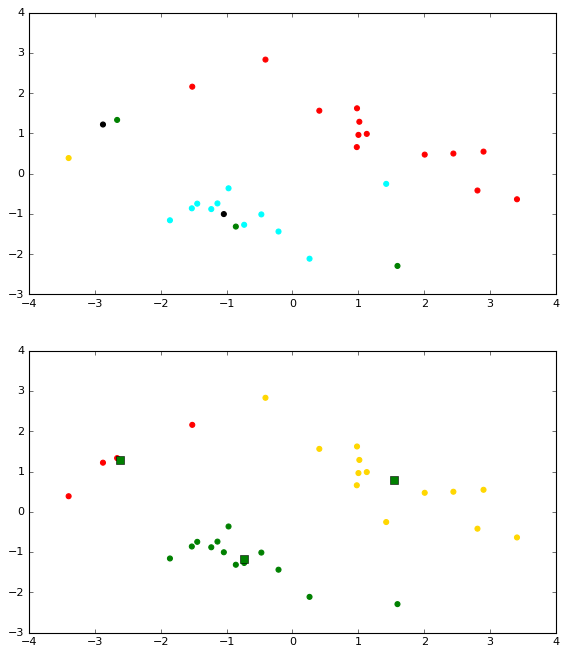

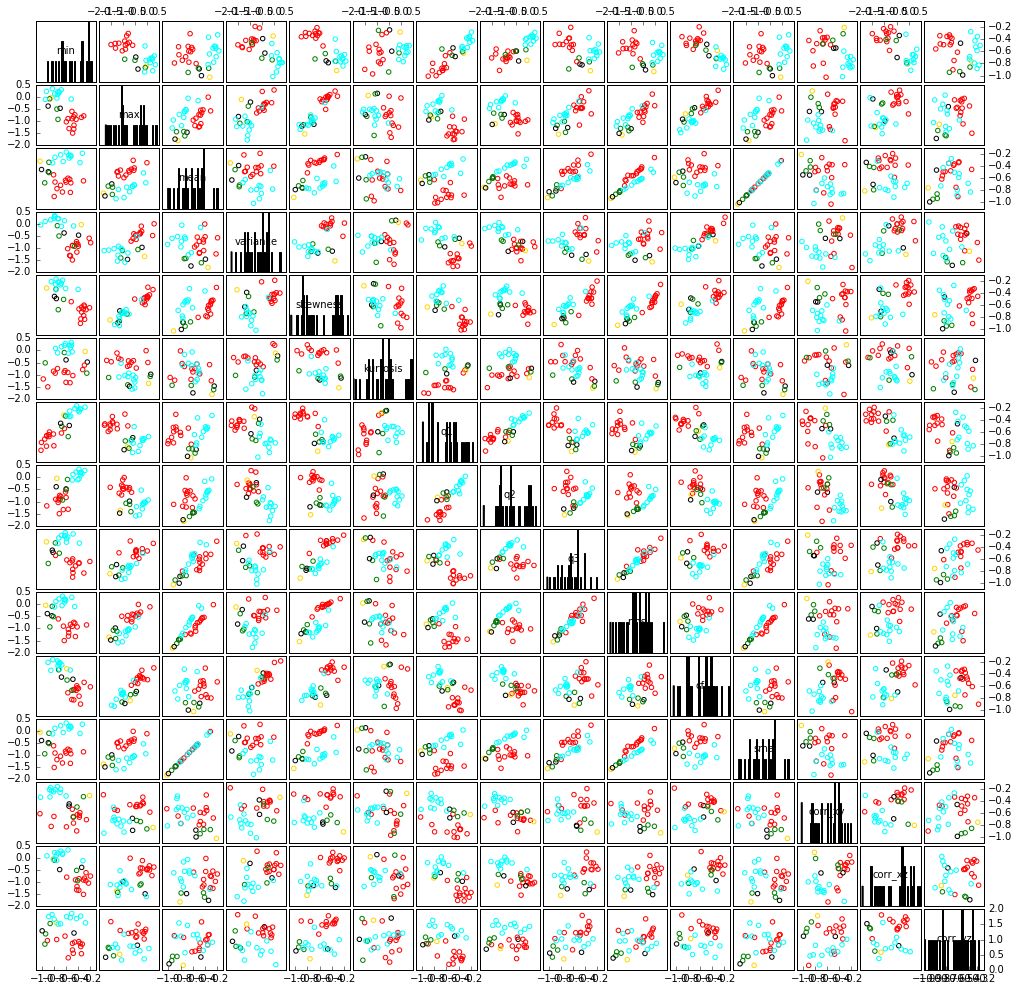

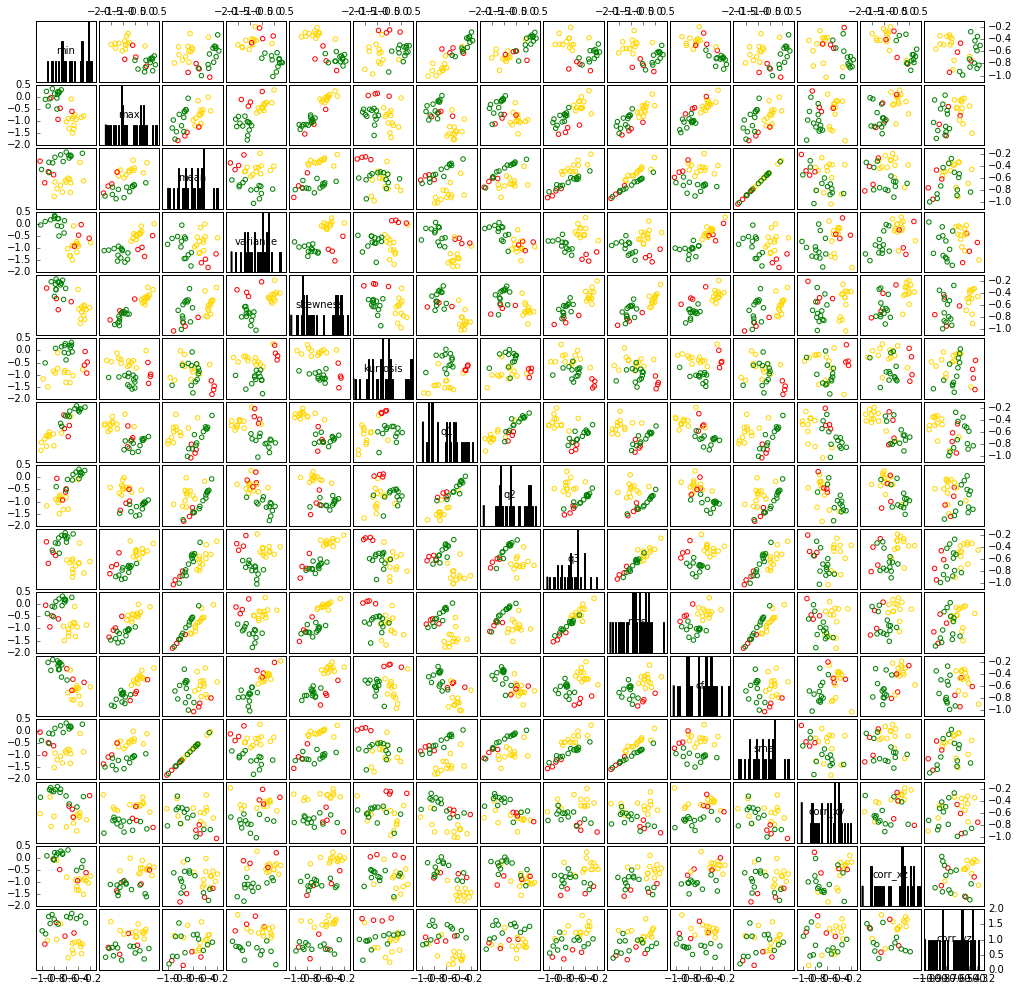

Category red characteristics


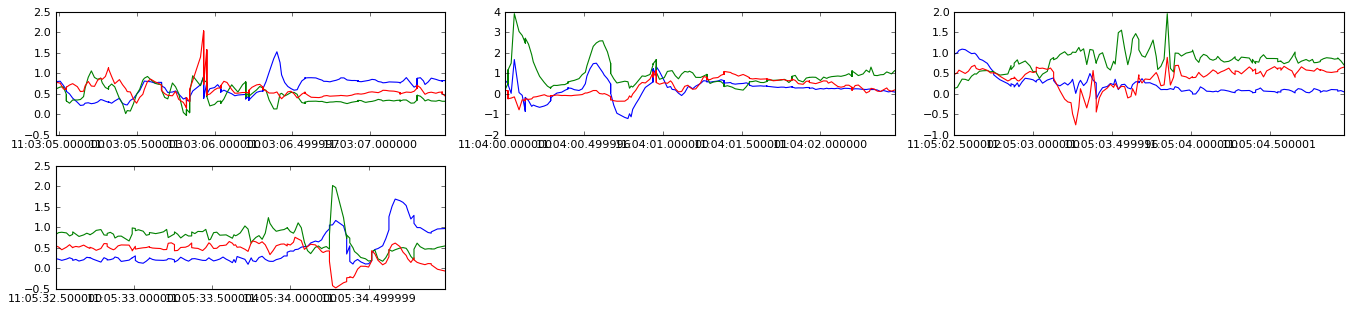

Category gold characteristics


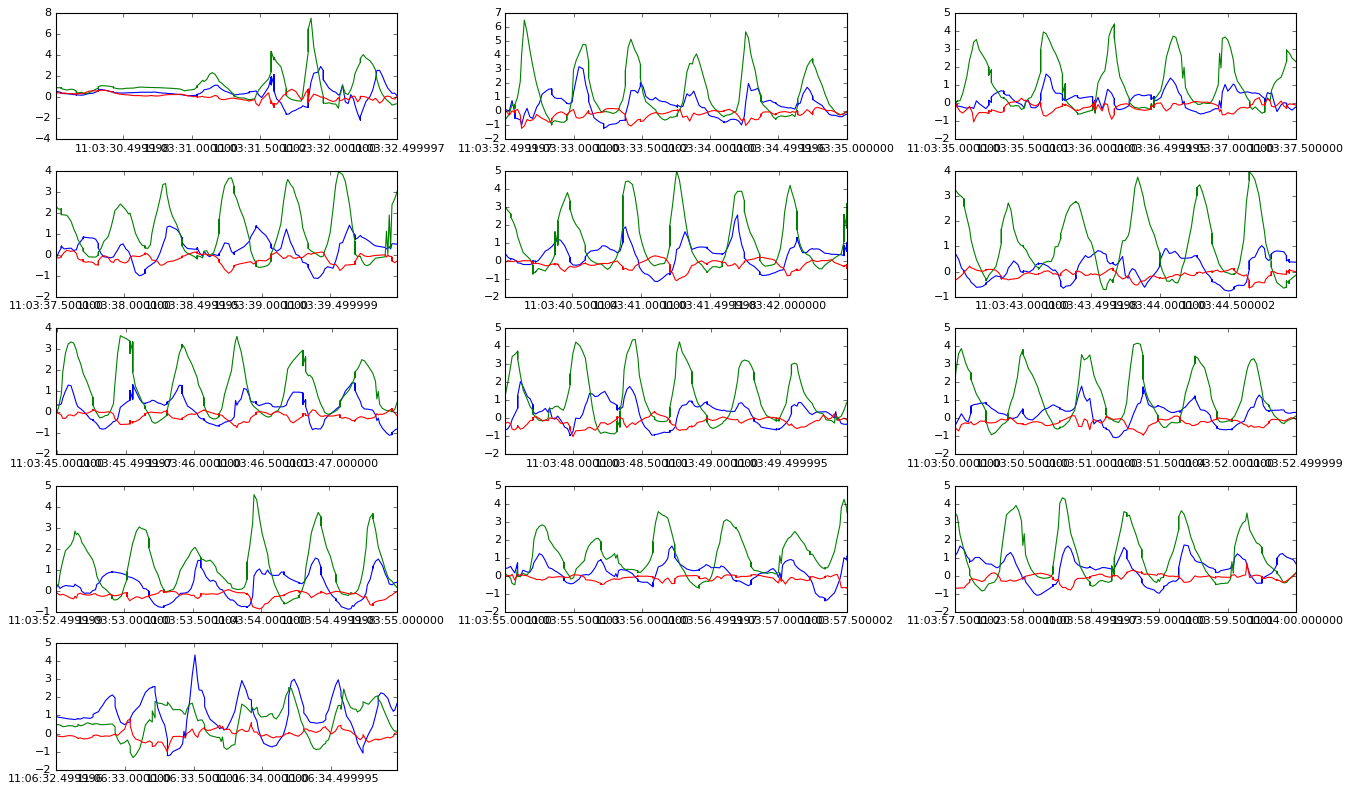

Category green characteristics


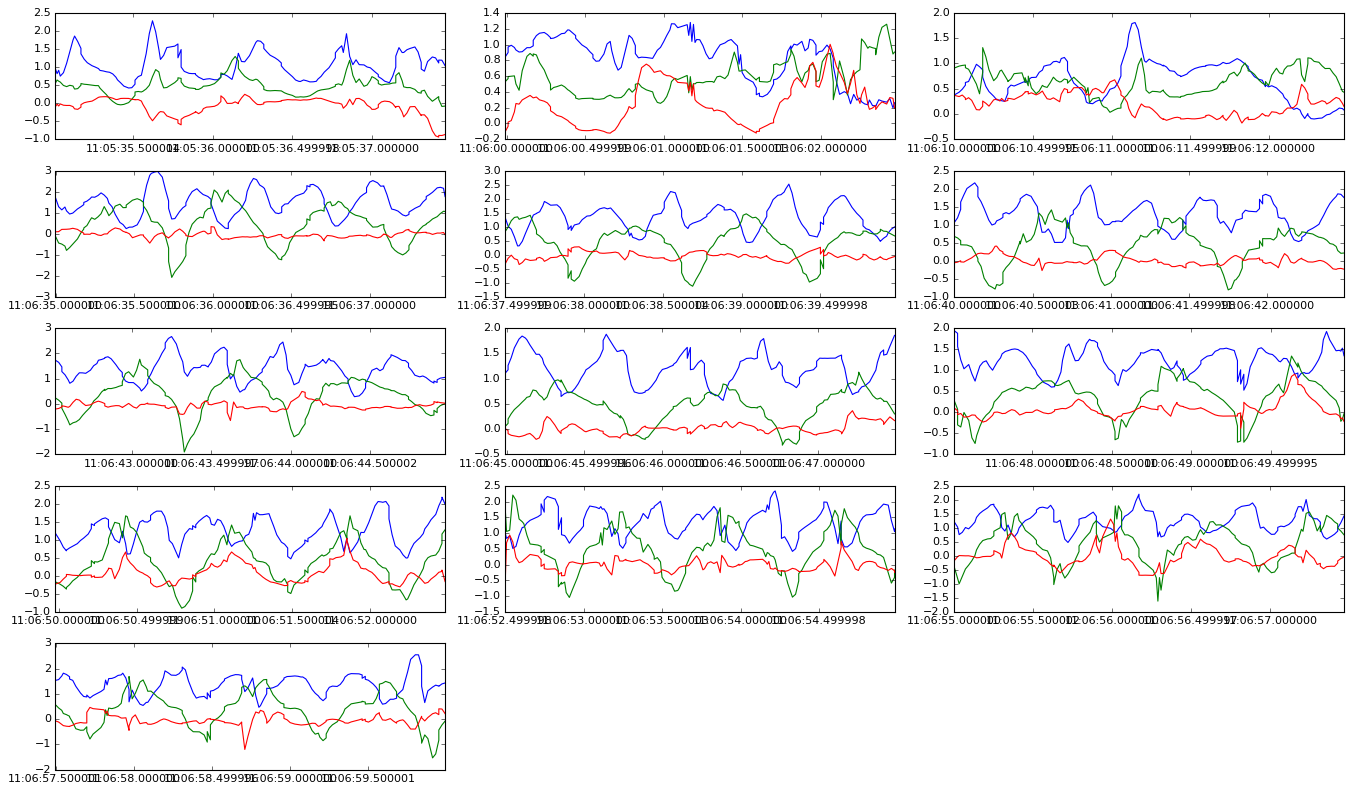

In [3]:
cluster=3
normalized_vector=a.normalize_vector(a.get_movement_feature(a.get_movement_segment(0.08)))
label_color = map(lambda x:to_color(x['info'],movement,a.color),normalized_vector)
print '\n'.join([str(mstats.normaltest(np.array(map(lambda x:(x['features'][i]),normalized_vector)))) for i in range(len(a.feature_list))])
idx=a.PCA_kmeans(normalized_vector,cluster,color=label_color)
s.scatterplot_matrix(np.transpose(map(lambda x:x['features'],normalized_vector)),a.feature_list,color=label_color, facecolors='none')
s.scatterplot_matrix(np.transpose(map(lambda x:x['features'],normalized_vector)),a.feature_list,color=map(lambda x:a.color[x], idx), facecolors='none')
plt.show()
for i in range(cluster):
    cat_feature=filter(lambda x:x[1]==i,zip(normalized_vector,idx))
    print "Category %s characteristics" % str(a.color[i])
    fig = plt.figure( figsize=(17, 2*(len(cat_feature)/3+1)), dpi=80)
    for i in range(len(cat_feature)):
        obs = cat_feature[i][0]
        label = cat_feature[i][1]
        start=obs['info'][0]
        end=obs['info'][1]
        avc=obs['info'][2]
        m=a.filter_motion(a.sample,start,end)
        # print obs['features'],'category ' +str(label)+' '+str(len(m))
        plt.subplot(len(cat_feature)/3+1,3,i+1)
        # plt.ylim(-4, 4)
        a.motion_plot(m,plt)
    plt.tight_layout()
    plt.show()

LR: 0.766667 (0.249444)
LDA: 0.600000 (0.290593)
KNN: 0.766667 (0.249444)
CART: 0.700000 (0.286744)
NB: 0.766667 (0.249444)
SVM: 0.766667 (0.249444)


/usr/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


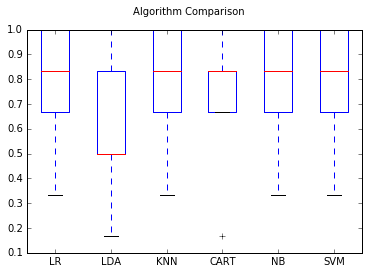

In [4]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
X = map(lambda x:x['features'],normalized_vector) # array[:,0:8]
Y = label_color # array[:,8]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

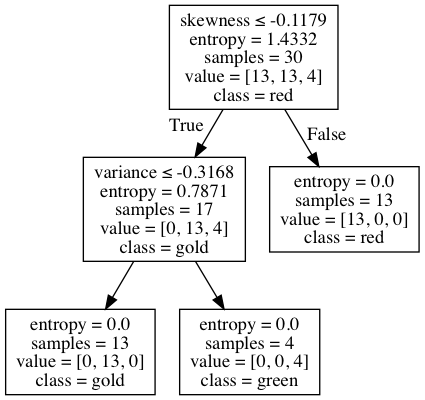

In [8]:
from sklearn import tree
import pydotplus
from IPython.display import Image
X = map(lambda x:x['features'],normalized_vector) 
Y = map(lambda x:a.color[x],idx)
clf = tree.DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X,Y)
dot_data=tree.export_graphviz(clf,out_file=None)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=a.feature_list,class_names=a.color[0:6],special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())